In [4]:
%pwd

'/data/Zhaijx/lijz/Some_task/Monosome_project/27_SPARP-seq_github/1_mod_script'

## 1. load function

- Loading the public package from python

In [16]:
import sys
import pysam
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.signal import find_peaks

In [2]:
%config InlineBackend.figure_format = 'retina'

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager
import matplotlib as mpl
import matplotlib.patches as mp
import seaborn as sns

font_dirs = ['./SPARP_analysis_tools/fonts/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
import pandas as pd
import numpy as np
import pysam

- Loading the customed module

In [4]:
sys.path.append('./SPARP_analysis_tools')

In [5]:
%load_ext autoreload
%autoreload 1
%aimport flepseq
%aimport plot

- load customed fucntion

In [35]:
def get_one_sample_dfs(mRNA, 
                       df, 
                       bin_length = 10, 
                       max_length = 300):
    df1 = df.query('mRNA.isin(@mRNA)')
    d1 = pd.DataFrame({"length": range(np.digitize(10, range(1, 300, bin_length)), 
         np.digitize(max_length-1, range(1, 300, bin_length))+1, 1)})
    
    if len(df1) == 0:
        d = d1
        d["count"] = 0
    else:
        x = df1.polya_length
        x = x[(x>=10) & (x<max_length)]
        x = pd.Series(np.digitize(x, range(1, 300, bin_length))).value_counts().sort_index()
        d = pd.DataFrame(x)
        d.columns = ["count"]
        d["length"] = d.index
        d = d1.merge(d, on="length", how="left").fillna(0)
        d.index = d["length"]
        d["count"] = d["count"]/d["count"].sum()
        
    return d

In [36]:
def plot_mRNAs_tissues(mRNA, 
                       dfs, 
                       samples, 
                       bin_length = 10, 
                       figsize = [3, 3], 
                       vmax = 0.12, 
                       cmap = "RdYlBu_r", 
                       title = 'Result'):
    result_df = {}
    for df, sample in zip(dfs, samples):
        ratio = get_one_sample_dfs(mRNA, df, bin_length)["count"].values
        result_df[sample] = ratio
        
    result_df = pd.DataFrame(result_df).T
    
    h = sns.clustermap(
        result_df,
        row_cluster=False,
        col_cluster=False,
        cmap=cmap,
        figsize=figsize,
        vmin=0, vmax=vmax
    )
    
    h.ax_heatmap.set_yticklabels(h.ax_heatmap.get_yticklabels(), fontsize=10, rotation=0)
    h.ax_heatmap.tick_params(right=False, bottom=False, labelright=True, labelbottom=False)
    h.ax_heatmap.set_xlabel(title)
    h.ax_heatmap.set_ylabel("")
    h.cax.set_visible(False)


___
## 2. get raw read information
- using `Monosome` as example

### 2.1. load `monosome` data as example
- Omits loading of other data

In [6]:
read_info_mono_rep1 = pd.read_csv('/public/home/shuy/nanopore_result/20240112_293T_monosome_bc04/results/20240114_293T_monosome_bc04.read.info.txt',sep = '\t')
read_info_mono_rep2 = pd.read_csv("/public/home/shuy/nanopore_result/20241015_293T_monosome_bc07/results/20241015_293T_monosome_bc07.read.info.txt",sep = "\t")

/tmp/ipykernel_125386/1006016079.py:1: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  read_info_mono_rep1 = pd.read_csv('/public/home/shuy/nanopore_result/20240112_293T_monosome_bc04/results/20240114_293T_monosome_bc04.read.info.txt',sep = '\t')
/tmp/ipykernel_125386/1006016079.py:2: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  read_info_mono_rep2 = pd.read_csv("/public/home/shuy/nanopore_result/20241015_293T_monosome_bc07/results/20241015_293T_monosome_bc07.read.info.txt",sep = "\t")


In [9]:
read_info_mono_sum = pd.concat([read_info_mono_rep1, read_info_mono_rep2], ignore_index=True)

In [10]:
read_info_mono_sum.head(3)

,Unnamed: 0,read_core_id,chr,read_start,read_end,read_strand,read_exon_total_num,mRNA,mRNA_intron_num,mRNA_start,...,longest_continous_a_length,init_polya_start,init_polya_end,init_polya_start_base,init_polya_end_base,init_polya_length,end_polyA_type,end5ss_type,low_accuracy_3end_mapped,type
0,0.0,"4d7ff721-ad9e-42f0-8590-da52f6d6b2a8,chr1,9239...",chr1,923923,940192,-,8,ENST00000616016.5,13,923924,...,0.00,1390,9239,116,120,763.50,5,0,False,polya_3_not_in_last_exon
1,1.0,"54997a12-df0a-403c-aaab-67584bea58e1,chr1,9240...",chr1,924043,924270,+,1,ENST00000616016.5,13,923924,...,2.43,6620,6654,327,328,2.43,1,0,True,elongating_3_mapping_low_accuracy
2,2.0,"2db45cfa-9ed2-4100-8ce1-7a34a8584583,chr1,9242...",chr1,924295,924545,+,1,ENST00000616016.5,13,923924,...,4.47,28585,32264,2264,2268,328.77,5,0,True,polya_3_not_in_last_exon


___
### 2.2. draw the `polyA length` distirbution for **all reads**

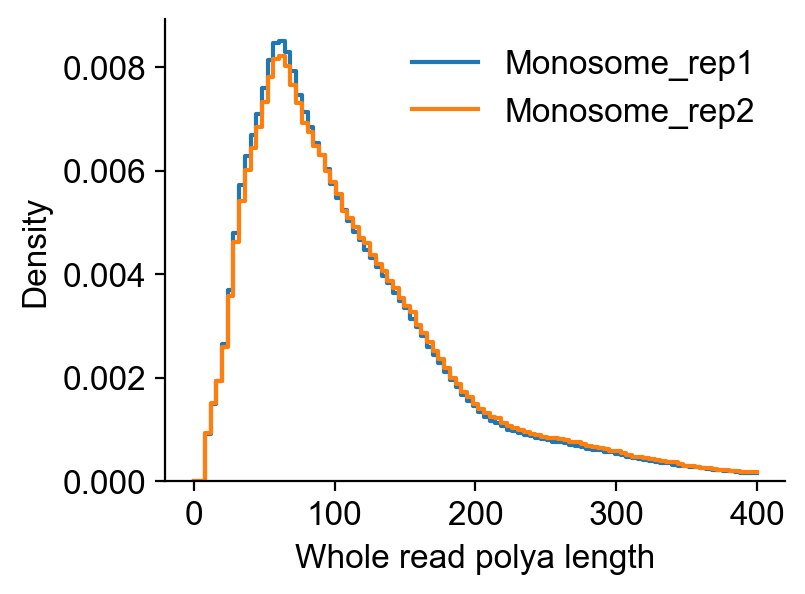

In [12]:
data = [read_info_mono_rep1.query('polya_length > 10').polya_length,
        read_info_mono_rep2.query('polya_length > 10').polya_length]

bins = np.linspace(0, 400, 100)
plot.step_histplot(*data,
                   bins = bins, 
                   labels=['Monosome_rep1','Monosome_rep2'], 
                   xlabel='Whole read polya length')
plt.savefig(f'PolyA_whole_pattern.svg')

___
### 2.3. find **highest peak** of `PolyA`

In [7]:
samples_2_reps = [read_info_mono_rep1, read_info_mono_rep2]
names_2_reps = ["Mono_rep1","Mono_rep2"]
example_dic = dict(zip(names_2_reps, samples_2_reps))

In [8]:
for name in example_dic.keys():
    sample = example_dic[name]
    hist, edges = np.histogram(sample.query('400>polya_length>10')['polya_length'], bins=100)
    hist = hist/hist.sum()
    
    peak_his,_=find_peaks(hist, distance=10, prominence=0.00025)
    mode_bins=[(edges[i],edges[i+ 1])for i in peak_his]
    
    peaks=[(x+y)/2 for x, y in mode_bins]
    peak = round(peaks[0], 3)
    
    print(f"{name}: the highest peak located at {peak}A.\t")

Mono_rep1: the highest peak located at 62.657A.	
Mono_rep2: the highest peak located at 62.657A.	


___
### 2.4. get median `poly(A)` length

In [9]:
polyA_median_dic = {}

for name in tqdm(example_dic.keys(), total = len(example_dic)):
    sample = example_dic[name]
    sample = sample.query('polya_length > 10')
    mRNA_median = sample.groupby('mRNA').agg({"polya_length": [len, np.median]})
    mRNA_median = mRNA_median.reset_index()
    mRNA_median.columns = ["mRNA", "polyA_count", "polyA_median"]

    gene_list = mRNA_median.query('polyA_count>10').mRNA.tolist()
    sample_filter = mRNA_median.query('mRNA.isin(@gene_list)')
    polya_list = sample_filter['polyA_median'].tolist()

    polyA_median_dic[name] = polya_list

100%|██████████| 2/2 [00:05<00:00,  2.96s/it]


- create dataframe for draw the swarmplot

In [10]:
max_length = max(len(val) for val in polyA_median_dic.values())
for key in polyA_median_dic:
    polyA_median_dic[key] += [None] * (max_length - len(polyA_median_dic[key]))
df_sw = pd.DataFrame(polyA_median_dic)
df_sw.head(3)

,Mono_rep1,Mono_rep2
0,115.74,125.870
1,239.38,184.620
2,155.91,90.325


- draw swarmplot

/public/home/lijz/.local/lib/python3.8/site-packages/seaborn/categorical.py:3370: UserWarning: 13.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/public/home/lijz/.local/lib/python3.8/site-packages/seaborn/categorical.py:3370: UserWarning: 8.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/public/home/lijz/.local/lib/python3.8/site-packages/seaborn/categorical.py:3370: UserWarning: 19.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/public/home/lijz/.local/lib/python3.8/site-packages/seaborn/categorical.py:3370: UserWarning: 13.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


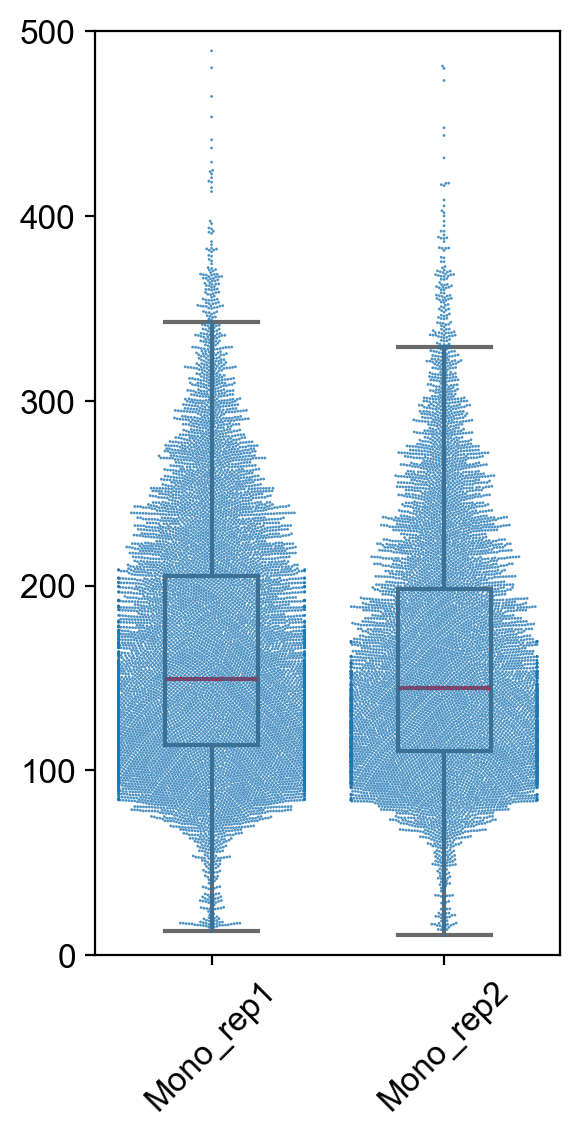

In [11]:
base_palette = sns.color_palette(n_colors=4)
palette = [base_palette[i//2] for i in range(2)] 

plt.figure(figsize=(3, 6))

sns.swarmplot(
    data=df_sw,
    size=1,
    alpha=0.8,
    palette=palette)

sns.boxplot(
    data=df_sw,
    showfliers=False,      
    patch_artist=True,     
    widths=0.4,            
    boxprops=dict(edgecolor='dimgray', linewidth=1.5, facecolor='none'),  
    whiskerprops=dict(color='dimgray', linewidth=1.5), 
    capprops=dict(color='dimgray', linewidth=1.5),     
    medianprops=dict(color='red', linewidth=1.5))

plt.ylim(0, 500)
plt.title("")
plt.xticks(rotation=45)
plt.show()

___
### 2.5 merge the data

- Using this for analysising the relationship between the `PolyA length` and `expression`.
- Modifiy the `dictionary` of `example_dic` to suit your own data.

In [12]:
merge_df = None  

for name in tqdm(example_dic.keys(), total = len(example_dic)):
    sample = example_dic[name]
    # Filter the sample
    sample_fl = sample.query('polya_length > 10')
    
    # Group by mRNA, and aggregate polya_length to get count, median, and list of polya_lengths
    polyA_list = sample_fl.groupby('mRNA').agg(
        polyA_count=('polya_length', len),
        polyA_median=('polya_length', np.median),
        polyA_list=('polya_length', list)).reset_index()  # Add a new column for the list of polya_length
        
    # Rename columns to include the name
    polyA_list.columns = [
        "mRNA", 
        f"polyA_reads_count_{name}", 
        f"polyA_median_{name}",  
        f"polyA_length_{name}"]  # The new list column for polya lengths

    total_counts = sample['mRNA'].count()
    counts_list = sample.groupby('mRNA').size().reset_index(name=f"raw_counts_{name}")
    counts_list[f"CPM_{name}"] = (counts_list[f"raw_counts_{name}"] / total_counts)*1e6
    tmp_merge_df = pd.merge(polyA_list,counts_list,on='mRNA',how='outer').fillna(0)
    
    # Merge with the final DataFrame as before
    if merge_df is None:
        # First iteration, set merged_df to this dataframe
        merge_df = tmp_merge_df
    else:
        merge_df = pd.merge(merge_df, 
                            tmp_merge_df, 
                            on="mRNA", 
                            how="outer").fillna(0)

100%|██████████| 2/2 [00:14<00:00,  7.28s/it]


- Check the merge_df

In [13]:
merge_df.head(3)

,mRNA,polyA_reads_count_Mono_rep1,polyA_median_Mono_rep1,polyA_length_Mono_rep1,raw_counts_Mono_rep1,CPM_Mono_rep1,polyA_reads_count_Mono_rep2,polyA_median_Mono_rep2,polyA_length_Mono_rep2,raw_counts_Mono_rep2,CPM_Mono_rep2
0,ENST00000000233.10,551.0,115.74,"[146.59, 123.4, 100.84, 115.95, 94.72, 49.67, ...",675.0,97.921369,210.0,125.870,"[222.94, 85.23, 154.7, 233.35, 101.6, 96.38, 7...",241.0,108.483011
1,ENST00000000412.8,181.0,239.38,"[255.74, 16.54, 187.29, 55.99, 13.54, 167.23, ...",235.0,34.091143,61.0,184.620,"[66.77, 77.95, 341.53, 35.11, 198.61, 173.14, ...",77.0,34.660547
2,ENST00000000442.11,71.0,155.91,"[122.32, 84.28, 159.53, 26.98, 85.77, 91.01, 1...",89.0,12.911114,28.0,90.325,"[46.05, 131.63, 202.08, 176.37, 238.48, 253.45...",35.0,15.754794


- save to the pickle
    - *We've constructed a pickle file of the* **all samples** *from the article to make it easy to load directly for testing.*

In [ ]:
with open(file_path, 'wb') as fh:
    pickle.dump(merge_df, fh)

___
### 2.6 Research the correlation between `CPM` and `PolyA`
- load pickle of example data 
- load the `half of life` data
- load the `gene ←→ mRNA transform` data

In [17]:
with open("./Example_files/20250121_cpm_polyA.pickle", "rb") as fh:
    merge_df = pickle.load(fh)

In [22]:
merge_df_gene = merge_df[['polyA_median_Mono_rep1','polyA_median_Mono_rep2',
                          'polyA_median_Poly23_rep1','polyA_median_Poly23_rep1',
                          'polyA_median_Poly45_rep1','polyA_median_Poly45_rep2',
                          'polyA_median_Poly67_rep1','polyA_median_Poly67_rep2']]

In [23]:
half_life_data = pd.read_csv('./Example_files/human_mRNA_half_life_merge_geneid.txt', sep = '\t')
half_life_data.head(3)

,RepNam,halfLive_h,Ensembl_Gene,RefSeq_nuc1,Ensembl_nuc
0,NM_138370,1.98,ENSG00000162878.13,NM_138370,ENST00000294964.6
1,NM_001039664,1.98,NaN,NaN,NaN
2,NM_148966,1.98,NaN,NaN,NaN


In [25]:
gene_mRNA_transform = pd.read_csv("./Example_files/hg38_gene_info_rep.txt", sep = '\t')
gene_mRNA_transform.head(3)

/tmp/ipykernel_125386/733718779.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  gene_mRNA_transform = pd.read_csv("./Example_files/hg38_gene_info_rep.txt", sep = '\t')


,Gene stable ID,Gene stable ID version,Transcript stable ID,Transcript stable ID version,Gene start (bp),Gene end (bp),Transcript start (bp),Transcript end (bp),Ensembl Canonical,Strand,Chromosome/scaffold name,Transcript length (including UTRs and CDS),Gene name,gene_length
0,ENSG00000210049,ENSG00000210049.1,ENST00000387314,ENST00000387314.1,577,647,577,647,1.0,1,MT,71,MT-TF,71
1,ENSG00000211459,ENSG00000211459.2,ENST00000389680,ENST00000389680.2,648,1601,648,1601,1.0,1,MT,954,MT-RNR1,954
2,ENSG00000210077,ENSG00000210077.1,ENST00000387342,ENST00000387342.1,1602,1670,1602,1670,1.0,1,MT,69,MT-TV,69


- draw `2D density`

In [26]:
two_rep_names = ["Mono_rep1","Mono_rep2","Poly23_rep1","Poly23_rep2","Poly45_rep1","Poly45_rep2","Poly67_rep1","Poly67_rep2"]

  0%|          | 0/8 [00:00<?, ?it/s]

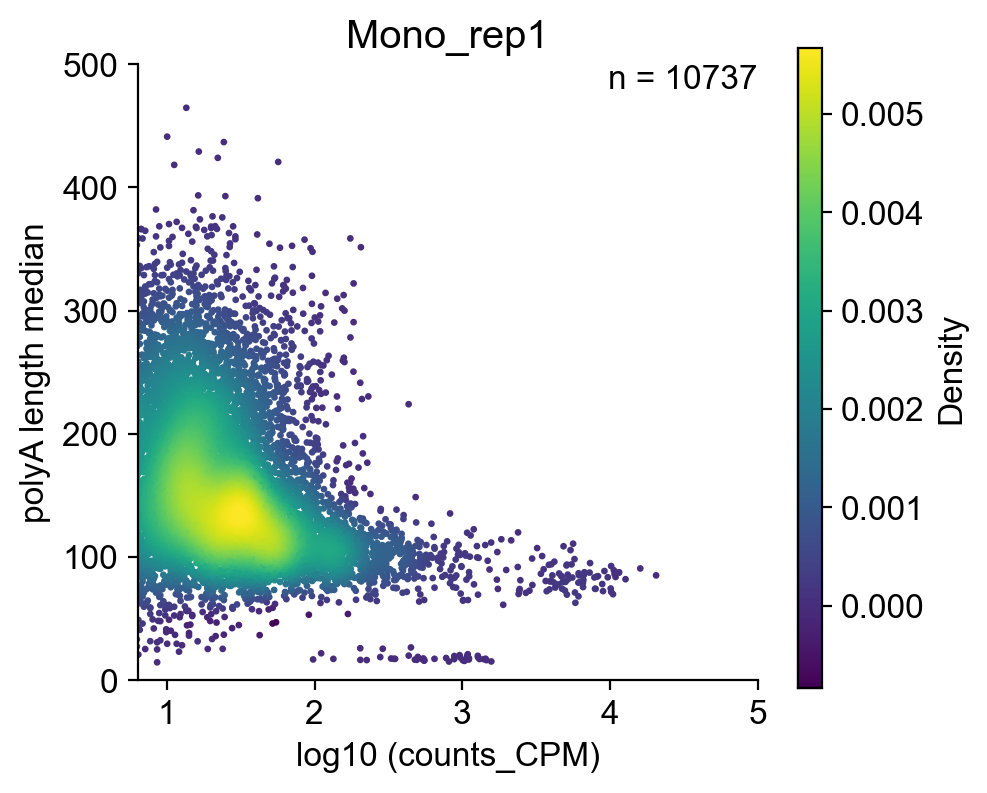

 12%|█▎        | 1/8 [00:00<00:05,  1.30it/s]

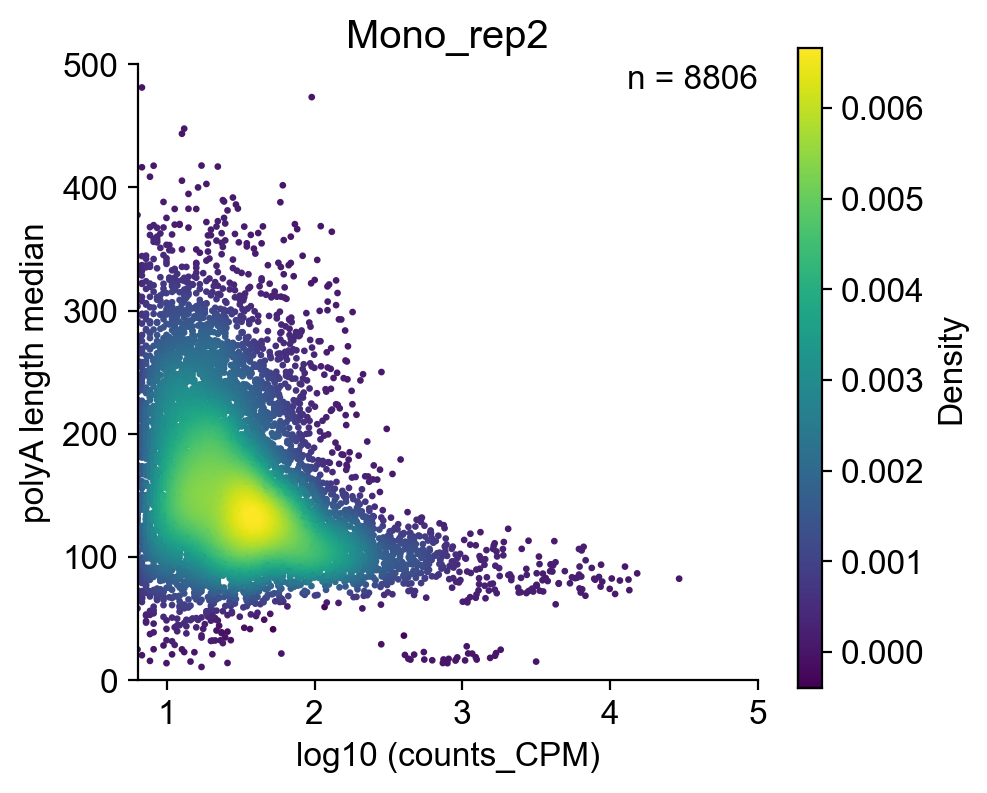

 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

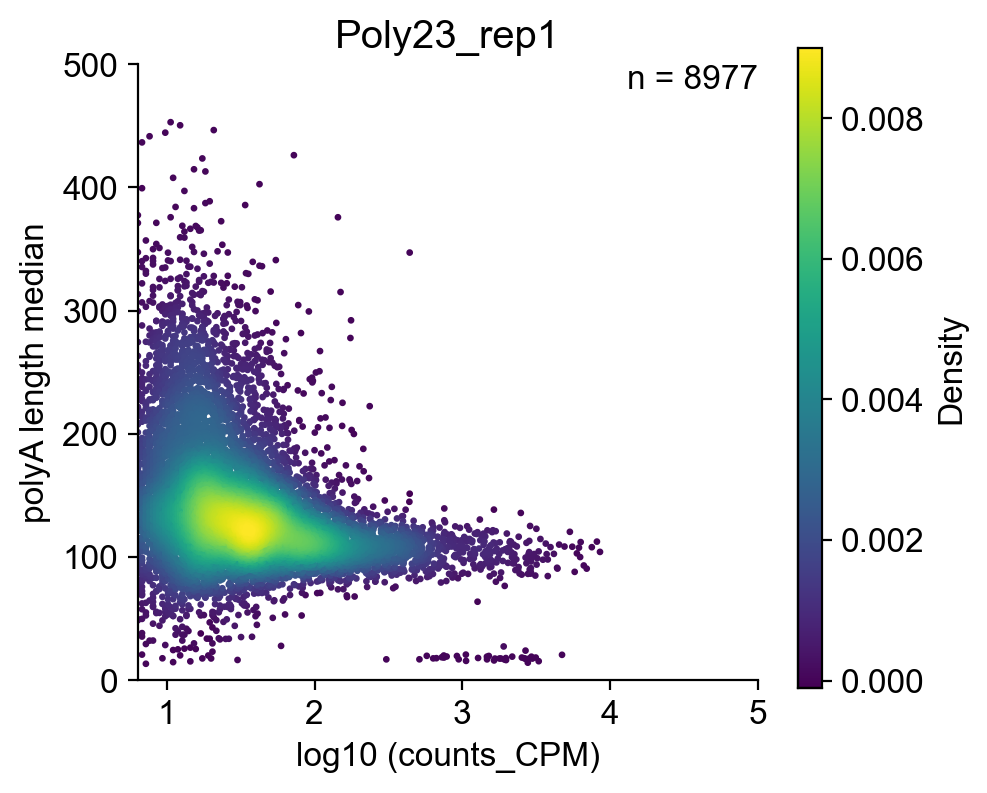

 38%|███▊      | 3/8 [00:01<00:03,  1.59it/s]

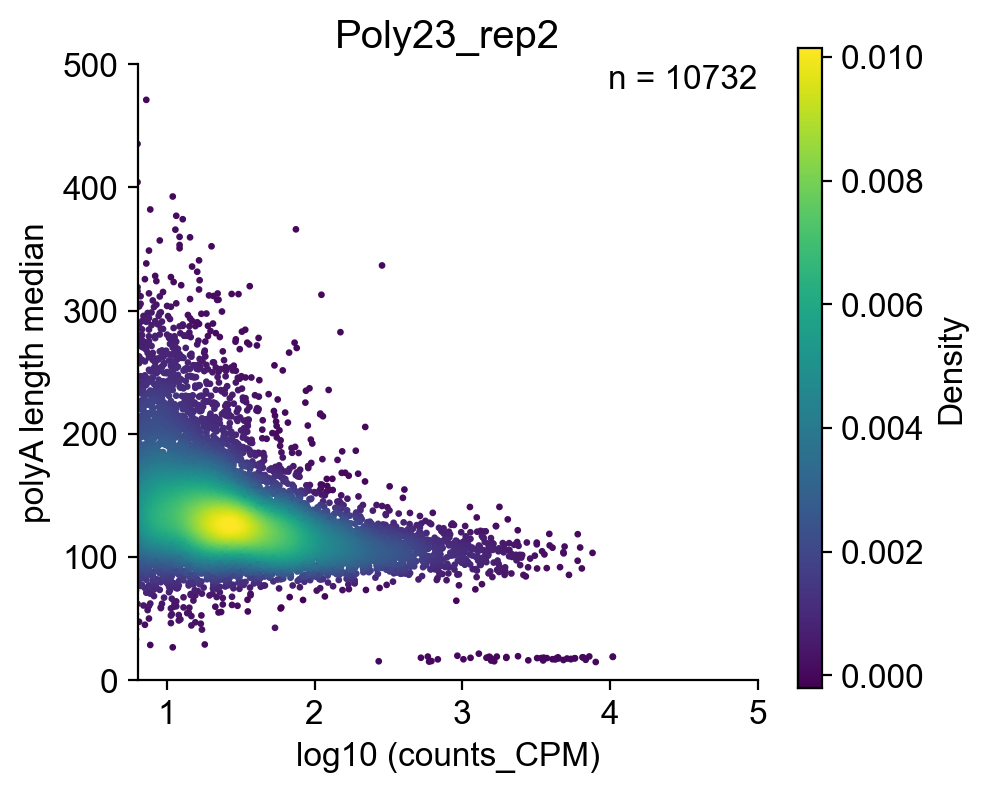

 50%|█████     | 4/8 [00:02<00:02,  1.61it/s]

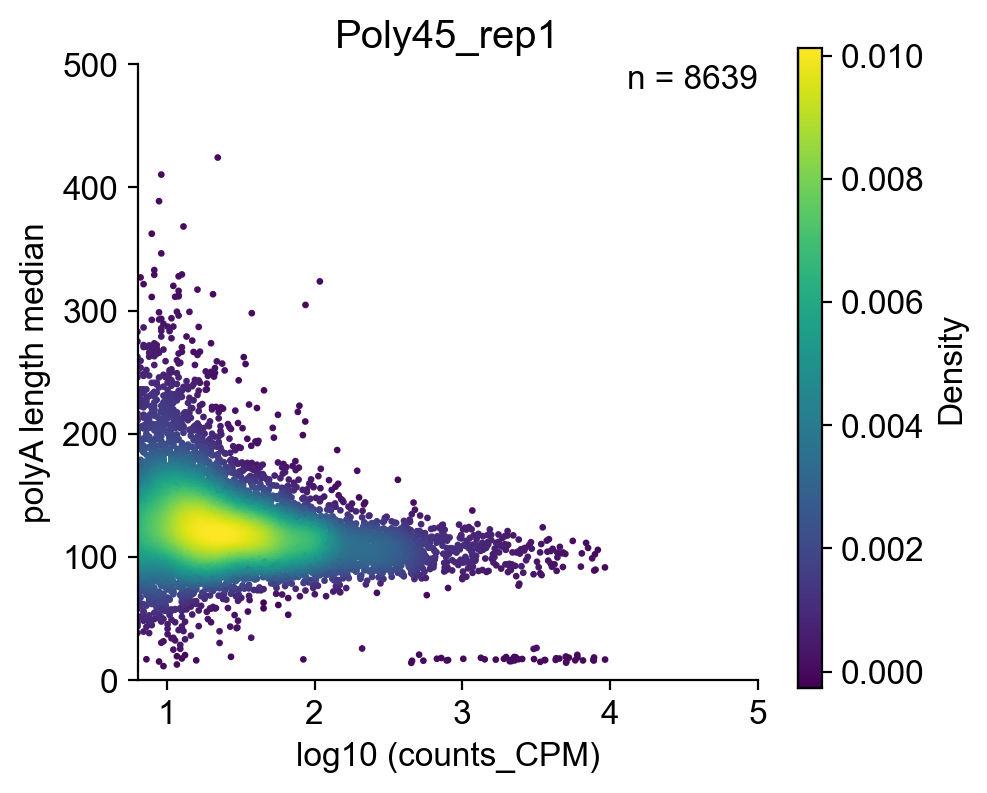

 62%|██████▎   | 5/8 [00:03<00:01,  1.67it/s]

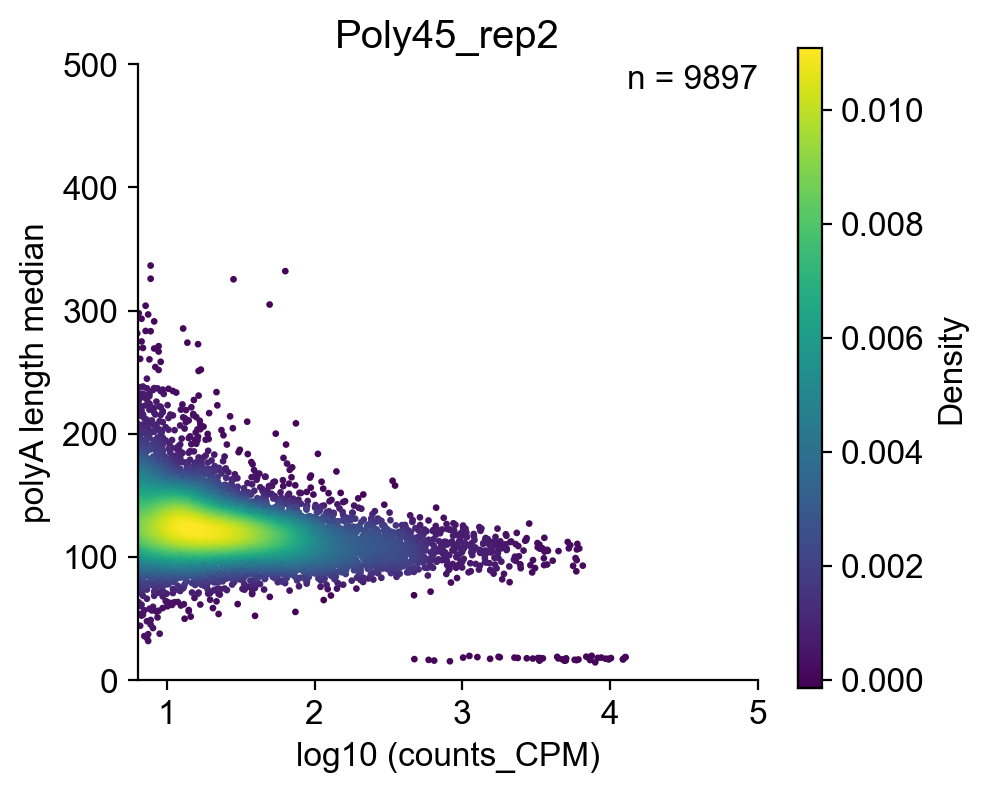

 75%|███████▌  | 6/8 [00:04<00:01,  1.11it/s]

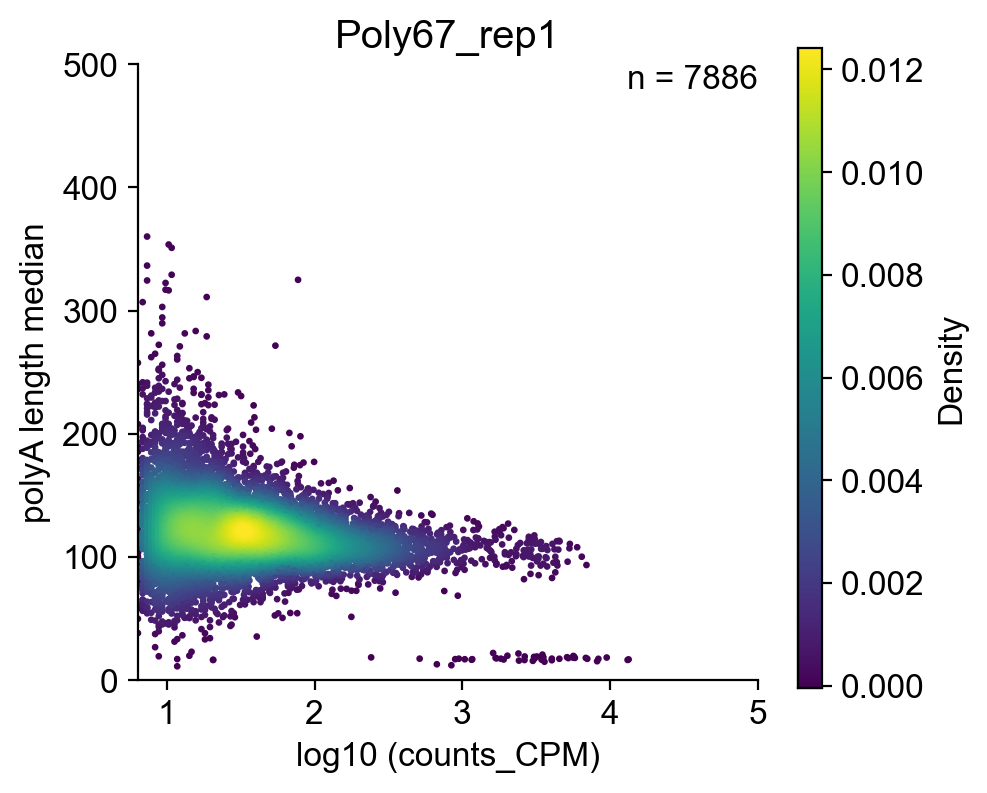

 88%|████████▊ | 7/8 [00:05<00:00,  1.25it/s]

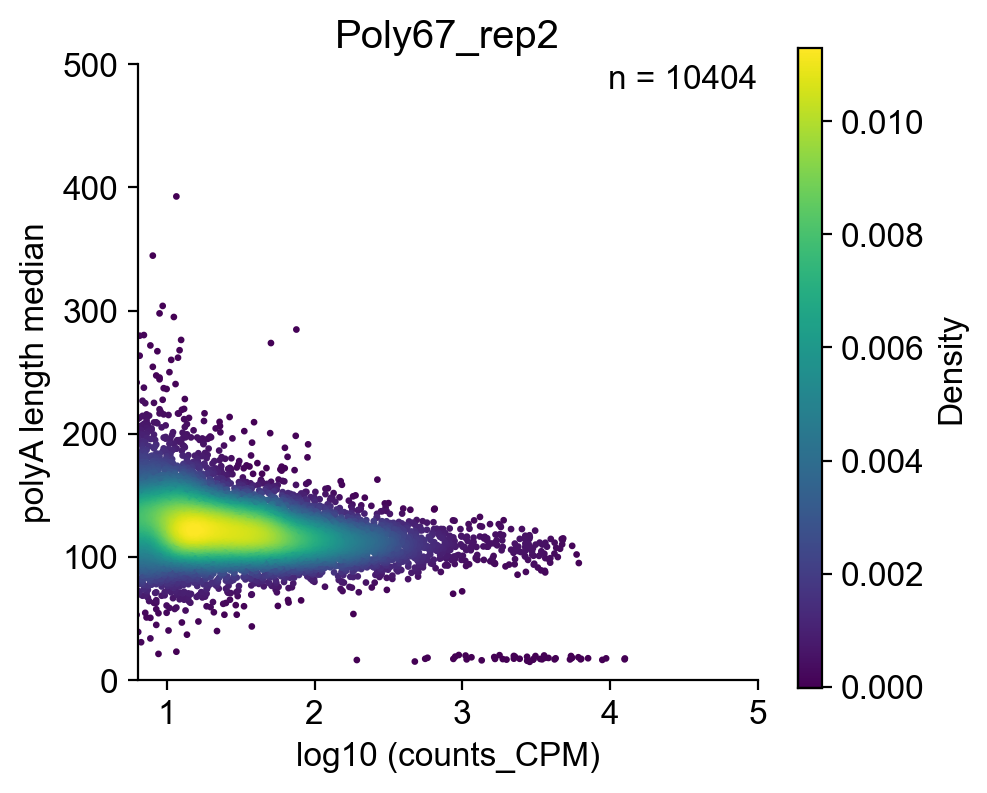

100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


In [28]:
for sample in tqdm(two_rep_names, total = len(two_rep_names)):

    CPM = f"CPM_{sample}"
    polyA_reads_count = f"polyA_reads_count_{sample}"
    polyA_median = f"polyA_median_{sample}"

    df_ = merge_df.query(f'{polyA_reads_count} > 10').reset_index()
    ax = plot.density_scatter(
        np.log10(df_[CPM]),
        df_[polyA_median],
        s=2)

    ax.set_xlabel('log10 (counts_CPM)')
    ax.set_ylabel('polyA length median')

    ax.set_xticks([-1, 0, 1, 2, 3, 4, 5])
    ax.set_yticks([0, 100, 200, 300, 400, 500])

    ax.set_xlim(0.8, 5)
    ax.set_ylim(-0.1, 500)
    ax.set_title(sample)

    n_points = len(df_[CPM])
    ax.text(5, 500, 
            f'n = {n_points}', 
            fontsize=12, 
            ha='right', 
            va='top')
    
    sns.despine()
    plt.show()

___
### 2.7. `PolyA` length Heatmap

- load data

In [ ]:
read_info_poly23_rep1 = pd.read_csv(xxx, sep = '\t')
read_info_poly23_rep2 = pd.read_csv(xxx, sep = '\t')
read_info_poly45_rep1 = pd.read_csv(xxx, sep = '\t')
read_info_poly45_rep2 = pd.read_csv(xxx, sep = '\t')
read_info_poly67_rep1 = pd.read_csv(xxx", sep = '\t')
read_info_poly67_rep2 = pd.read_csv(xxx, sep = '\t')

all_read_infos = [read_info_mono_rep1,
                  read_info_mono_rep2,
                  read_info_poly23_rep1,
                  read_info_poly23_rep2,
                  read_info_poly45_rep1,
                  read_info_poly45_rep2,
                  read_info_poly67_rep1,
                  read_info_poly67_rep2]

all_samples = ["Mono_rep1","Mono_rep2",
              "Poly23_rep1","Poly23_rep2",
              "Poly45_rep1","Poly45_rep2",
              "Poly67_rep1","Poly67_rep2"]
              
# pk_data = {}
# pk_data["reads_info"] = all_read_infos
# pk_data["all_samples"] = all_samples
# with open("./Example_files/all_read_infos.pickle", 'wb') as fh:
#     pickle.dump(pk_data, fh)

- `High` expressed genes as example

In [31]:
house_keeping_gene_list = ['RRN18S', 'ACTB', 'GAPDH', 'PGK1', 'PPIA', 'RPL13A', 'RPLP0', 
                           'ARBP', 'B2M', 'YWHAZ', 'SDHA', 'GUSB', 'HMBS', 'HPRT1', 'TBP']
hkgl = gene_mRNA_transform.query('`Gene name`.isin(@house_keeping_gene_list)')['Transcript stable ID version'].tolist()

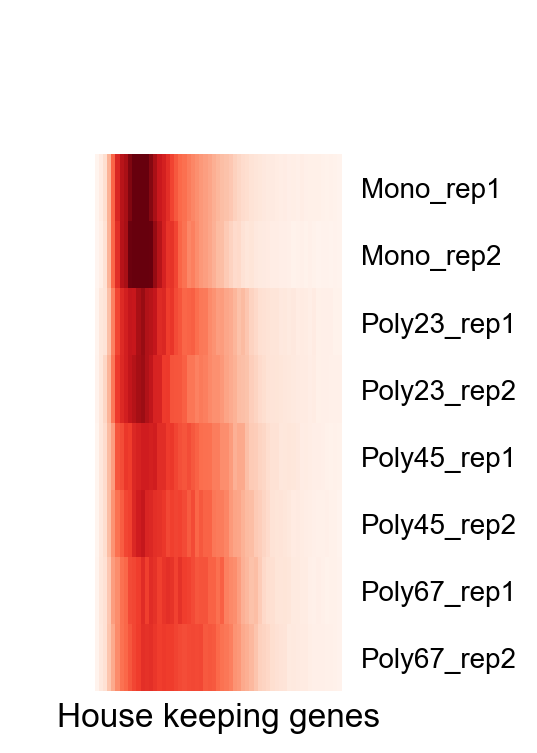

In [37]:
plot_mRNAs_tissues(hkgl, 
                   all_read_infos,
                   all_samples,
                   bin_length=5,
                   vmax=0.05,
                   figsize=[3, 4], 
                   title='House keeping genes',
                   cmap='Reds')

- low expression genes

In [38]:
low_expression_gene = merge_df.query('CPM_Mono_rep1 < 10')['mRNA']

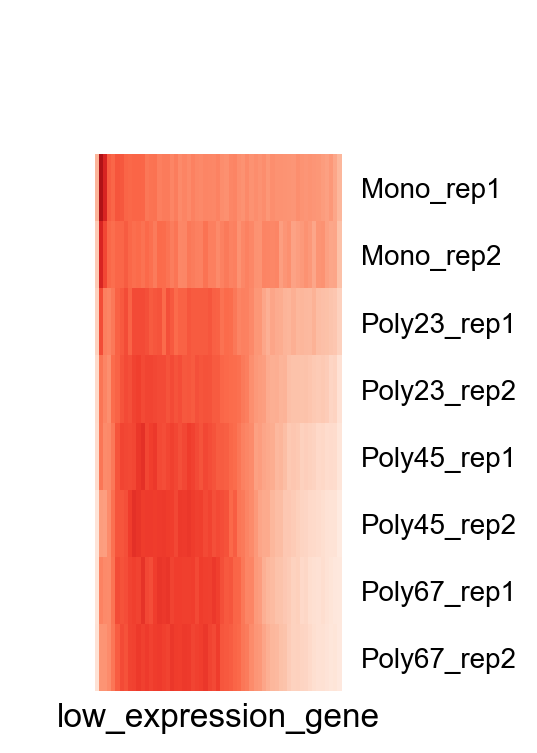

In [40]:
plot_mRNAs_tissues(low_expression_gene, 
                   all_read_infos,
                   all_samples,
                   bin_length=5,
                   vmax=0.04,
                   figsize=[3, 4], 
                   title='low_expression_gene',
                   cmap='Reds')

In [ ]:
polyA_length_name = polyA_length_sum.merge(polyA_length_sum_2rep_gene[['Gene stable ID','Gene stable ID version','Transcript stable ID version','Gene name','Chromosome/scaffold name','Strand','Gene start (bp)', 'Gene end (bp)','Transcript length (including UTRs and CDS)','gene_length']],
                                                                  how="left",
                                                                  left_on= "mRNA",
                                                                  right_on="Transcript stable ID version")

In [ ]:
polyA_length_name_half = polyA_length_name.merge(half_life_data[['halfLive_h','Ensembl_nuc']],
                                                                  how="left",
                                                                  left_on= "mRNA",
                                                                  right_on="Ensembl_nuc").fillna(0)

In [3]:
_list = ["featureCounts", "-T", "process_n", \
"-t", "exon", \
"-g", "gene_id", \
"-a", "exon_gtf", \
"-o", f"result.txt", \
'xxx.bam', \
'xxx.bam', \
'xxx.bam']
print(" ".join(_list))

featureCounts -T process_n -t exon -g gene_id -a exon_gtf -o result.txt xxx.bam xxx.bam xxx.bam
